# Ablation for Streisand Effect
Like in Golatkar's paper: Eternal sunshine of the spotless net

In [4]:
import sys

sys.path.append("../src/")
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from helpers.data_utils import UnlearningDataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def entropy(p, dim=-1, keepdim=False):
    entropy = -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(
        dim=dim, keepdim=keepdim
    )
    return entropy


def collect_prob(data_loader, model):
    all_probs = []
    model.eval()
    model.to(device)
    with torch.no_grad():
        for data, _ in tqdm(data_loader):
            data = data.to(device)
            output = model(data)
            probs = F.softmax(output, dim=-1)
            all_probs.append(probs) 
    return torch.cat(all_probs)


UDL = UnlearningDataLoader(
    dataset="cifar-100",
    batch_size=1,
    image_size=32,
    seed=13,
    is_vit=False,
    is_class_unlearning=False,
    class_to_forget=None,
)
dl, _ = UDL.load_data()
num_classes = len(UDL.classes)
input_channels = UDL.input_channels

In [5]:
original = torch.load('streisand/models/original.pth')
original_retain = collect_prob(dl["retain"], original)
original_forget = collect_prob(dl["forget"], original)
original_test = collect_prob(dl["test"], original)

gold = torch.load('streisand/models/gold.pth')
gold_retain = collect_prob(dl["retain"], gold)
gold_forget = collect_prob(dl["forget"], gold)
gold_test = collect_prob(dl["test"], gold)

relabel = torch.load('streisand/models/relabel.pth')
relabel_retain = collect_prob(dl["retain"], relabel)
relabel_forget = collect_prob(dl["forget"], relabel)
relabel_test = collect_prob(dl["test"], relabel)

our = torch.load('streisand/models/our.pth')
our_retain = collect_prob(dl["retain"], our)
our_forget = collect_prob(dl["forget"], our)
our_test = collect_prob(dl["test"], our)

  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [6]:
original_retain = entropy(original_retain)
original_forget = entropy(original_forget)
original_test = entropy(original_test)
# apply log
original_retain = torch.log(original_retain).to('cpu')
original_forget = torch.log(original_forget).to('cpu')
original_test = torch.log(original_test).to('cpu')
gold_retain = entropy(gold_retain)

gold_forget = entropy(gold_forget)
gold_test = entropy(gold_test)
# apply log
gold_retain = torch.log(gold_retain).to('cpu')
gold_forget = torch.log(gold_forget).to('cpu')
gold_test = torch.log(gold_test).to('cpu')

relabel_retain = entropy(relabel_retain)
relabel_forget = entropy(relabel_forget)
relabel_test = entropy(relabel_test)
# apply log
relabel_retain = torch.log(relabel_retain).to("cpu")
relabel_forget = torch.log(relabel_forget).to("cpu")
relabel_test = torch.log(relabel_test).to("cpu")

our_retain = entropy(our_retain)
our_forget = entropy(our_forget)
our_test = entropy(our_test)
# apply log
our_retain = torch.log(our_retain).to('cpu')
our_forget = torch.log(our_forget).to('cpu')
our_test = torch.log(our_test).to('cpu')

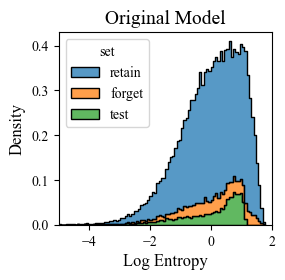

In [18]:
plt.rcParams["font.family"] = "Times New Roman" 

# Create a DataFrame combining the log entropy values and labels
data_original = pd.DataFrame(
    {
        "log_entropy": np.concatenate(
            [original_retain.to("cpu"), original_forget.to("cpu"), original_test.to("cpu")]
        ),
        "set": ["retain"] * len(original_retain)
        + ["forget"] * len(original_forget)
        + ["test"] * len(original_test),
    }
)

# Normalize each set separately
data_original["log_entropy"] = data_original.groupby("set")["log_entropy"].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Create the histogram plot with different colors for each data split
plt.figure(figsize=(2.75, 2.5))
sns.histplot(
    data=data_original,
    x="log_entropy",
    hue="set",
    multiple="stack",
    kde=False,
    stat="density",
    element="step",
)

plt.title("Original Model", fontsize=14)
plt.xlabel("Log Entropy", fontsize=12)
plt.xticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel("Density", fontsize=12) 
plt.xlim(-5, 2)
plt.ylim(0.0, 0.43)

plt.savefig(f"streisand/plots/original.png", dpi=300, bbox_inches='tight')
plt.show()

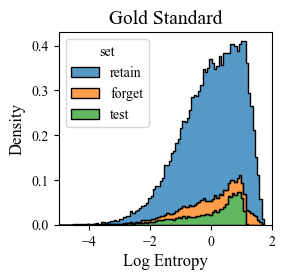

In [17]:
# Create a DataFrame combining the log entropy values and labels
data_gold = pd.DataFrame(
    {
        "log_entropy": np.concatenate(
            [gold_retain.to("cpu"), gold_forget.to("cpu"), gold_test.to("cpu")]
        ),
        "set": ["retain"] * len(gold_retain)
        + ["forget"] * len(gold_forget)
        + ["test"] * len(gold_test),
    }
)

# Normalize each set separately
data_gold["log_entropy"] = data_gold.groupby("set")["log_entropy"].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Create the histogram plot with different colors for each data split
plt.figure(figsize=(2.75, 2.5))
sns.histplot(
    data=data_gold,
    x="log_entropy",
    hue="set",
    multiple="stack",
    kde=False,
    stat="density",
    element="step",
)
plt.title("Gold Standard", fontsize=14)
plt.xlabel("Log Entropy", fontsize=12)
plt.xticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel("Density", fontsize=12)
plt.xlim(-5, 2)
plt.ylim(0.0, 0.43)

plt.savefig(f"streisand/plots/gold.png", dpi=300, bbox_inches='tight')
plt.show()

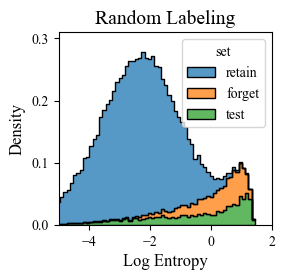

In [16]:
# Create a DataFrame combining the log entropy values and labels
data_relabel = pd.DataFrame(
    {
        "log_entropy": np.concatenate(
            [relabel_retain.to("cpu"), relabel_forget.to("cpu"), relabel_test.to("cpu")]
        ),
        "set": ["retain"] * len(relabel_retain)
        + ["forget"] * len(relabel_forget)
        + ["test"] * len(relabel_test),
    }
)

# Create the histogram plot with different colors for each data split
plt.figure(figsize=(2.75, 2.5))
sns.histplot(
    data=data_relabel,
    x="log_entropy",
    hue="set",
    multiple="stack",
    kde=False,
    stat="density",
    element="step",
)
plt.title("Random Labeling", fontsize=14)
plt.xlabel("Log Entropy", fontsize=12)
plt.xticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel("Density", fontsize=12)
plt.xlim(-5, 2)
plt.ylim(0.0, 0.31)

plt.savefig(f"streisand/plots/random_labeling.png", dpi=300, bbox_inches='tight')
plt.show()

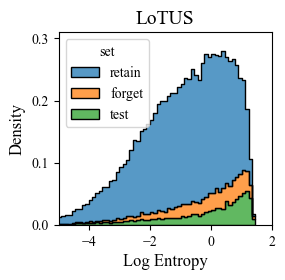

In [15]:
# Create a DataFrame combining the log entropy values and labels
data_our = pd.DataFrame(
    {
        "log_entropy": np.concatenate(
            [our_retain.to("cpu"), our_forget.to("cpu"), our_test.to("cpu")]
        ),
        "set": ["retain"] * len(our_retain)
        + ["forget"] * len(our_forget)
        + ["test"] * len(our_test),
    }
)

# Create the histogram plot with different colors for each data split
plt.figure(figsize=(2.75, 2.5))
sns.histplot(
    data=data_our,
    x="log_entropy",
    hue="set",
    multiple="stack",
    kde=False,
    stat="density",
    element="step",
)
plt.title("LoTUS", fontsize=14)
plt.xlabel("Log Entropy", fontsize=12)
plt.xticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel("Density", fontsize=12)
plt.xlim(-5, 2)
plt.ylim(0.0, 0.31)

plt.savefig(f"streisand/plots/ours.png", dpi=300, bbox_inches='tight')
plt.show()